<a href="https://colab.research.google.com/github/josephine-dworkin/capstone-rbf-fd/blob/main/RDF_FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

Parameters from Slobodan Milovanovic's computations

In [128]:
K = 100 # strike price
T = 1 # time
r = 0.03
sigma = 0.15
M = 10 ** 6

S_min, S_max = 0.0, 4 * K
N = 100 # number of nodes
m = 7 # stencil size
dt = 0.002
Nt = int(T / dt)

Generating nodes using sinh clustered mapping

In [129]:
def generate_clustered_nodes(N, S_min, S_max, K, alpha):
    xi = np.linspace(-1, 1, N)

    # Symmetric sinh mapping around 0
    # Gives more density near xi=0 (center)
    stretched = np.sinh(alpha * xi) / np.sinh(alpha)

    # Map stretched nodes into [S_min, S_max]
    # and center them around K
    midpoint = 0.5 * (S_min + S_max)
    half_width = 0.5 * (S_max - S_min)

    # Shift mapping so that the cluster center aligns with K
    shift = (K - midpoint) / half_width
    S_nodes = midpoint + half_width * (np.sinh(alpha * (xi + shift)) / np.sinh(alpha))
    return S_nodes

def generate_clustered_nodes(N, Smin, Smax, K, alpha):
    xi = np.linspace(-1, 1, N)
    stretched = np.sinh(alpha * xi) / np.sinh(alpha)
    midpoint = 0.5 * (S_min + S_max)
    half_width = 0.5 * (S_max - S_min)
    S_nodes = K + half_width * stretched
    return S_nodes

def generate_clustered_nodes2(N, Smin, Smax, K, alpha):
    xi = np.linspace(-1, 1, N)
    stretched = np.sinh(alpha * xi) / np.sinh(alpha)
    midpoint = 0.5 * (S_min + S_max)
    half_width = 0.5 * (S_max - S_min)
    S_nodes = K + half_width * stretched
    S_nodes_shift = S_nodes + 100
    return S_nodes_shift

S_nodes = generate_nodes(N, S_min, S_max, K, 3)

In [130]:
def generate_nodes(N, Smin, Smax, K, alpha):

    xi = np.linspace(0, 1, int(N * K / Smax))
    S_nodes_lower = K - (K - S_min) * np.sinh(alpha * xi) / np.sinh(alpha)

    yi = np.linspace(0, 1, int(N - N * K / Smax))
    S_nodes_upper = K + (S_max - K) * np.sinh(alpha * yi) / np.sinh(alpha)

    S_nodes = np.concatenate((S_nodes_lower,S_nodes_upper))
    return S_nodes

S_nodes = generate_nodes(N, S_min, S_max, K, 3)

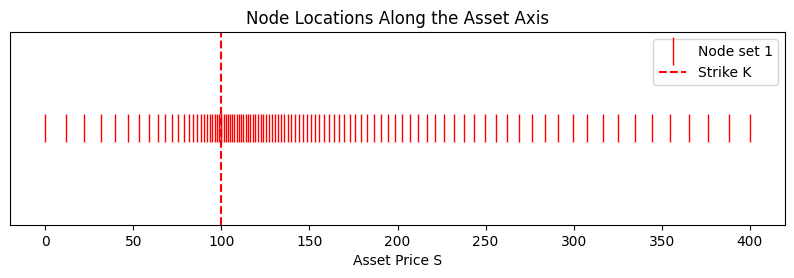

In [131]:
plt.figure(figsize=(10, 2.5))
plt.plot(S_nodes, np.zeros_like(S_nodes), '|', markersize=20, label='Node set 1', color='red')


plt.axvline(K, color='red', linestyle='--', label='Strike K')
plt.xlabel('Asset Price S')
plt.title('Node Locations Along the Asset Axis')
plt.yticks([])
plt.legend()
plt.show()

Building RBF weights